In [1]:
# 代码 5-1：获取MNIST数据集
import torch
if torch.cuda.is_available(): # 如果有可用的cuda设备，则设置为cuda
    device = 'cuda'
else: # 否则用cpu
    device = 'cpu'

import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((32, 32)),  # 变形为LeNet所需的输入形状(32 ×32)
    transforms.ToTensor(),  # 转换为tensor（注意，此处的tensor默认在CPU上储存）
    torchvision.transforms.Normalize((0.1307, ), (0.3081, )) # MNIST数据集标准化
])

## 获得训练数据的Dataset
trainset = torchvision.datasets.MNIST(root='./dataset', train=True, download=True, transform=transform)
## 获得验证数据的Dataset
testset = torchvision.datasets.MNIST(root='./dataset', train=False, download=True, transform=transform)

100.1%

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw


113.5%

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw


100.4%

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw


180.4%

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [2]:
# 代码5-2: 构建数据读取器
batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)  # 训练集进行打乱
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)  # 测试集不进行打乱

torch.Size([128, 1, 32, 32])
torch.Size([128])


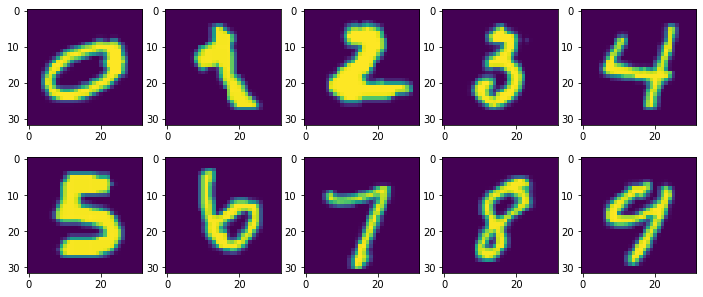

In [3]:
# 代码 5-3: 数据读取器图片展示
from matplotlib import pyplot as plt
from torchvision.utils import make_grid
images, labels = next(iter(trainloader))  # 获取训练集第一个批次中的图片及相应标签
print(images.shape)
print(labels.shape)

fig,ax = plt.subplots(2, 5, figsize=(12, 5)) # 设置画布大小
ax = ax.flatten()
for i in range(10):
    im = images[labels==i][0].reshape(32, 32)
    ax[i].imshow(im)
plt.show()

In [4]:
# 代码 5-4：构建LeNet-5模型
import torch.nn as nn
import torch.nn.functional as F

# 定义LeNet-5网络
class LeNet(nn.Module):
    '''
    为定义LeNet-5模型，需要继承nn.Module类，该类需要定义两个函数。
    1. __init__：初始化，这里采用nn.Sequential建立卷积神经网络
    2. forward(self,x)：定义前馈学习，x为输入的像素矩阵
    '''
    def __init__(self):
        super(LeNet, self).__init__() # 直接继承nn.Module的init
        ## 构建卷积层
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        ## 构建全连接层
        self.fc = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120), # 16*5*5为卷积层的输出维数, 120为第一个全连接层的输出节点个数
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        ) # 注意这里只进行了线性变换，没有接softmax变换，这是因为随后的损失函数中包含了softmax操作。

    def forward(self, x):
        feature = self.conv(x)
        output = self.fc(feature.view(x.size()[0], -1))  # 在卷积操作后，输出仍是tensor，需要进行flatten拉直再输入进全连接层
        return output
        
model = LeNet() # 实例化一个Lenet模型
model.to(device)  # 将模型中所有参数tensor切换到GPU存储模式

## 查看模型具体信息
from torchsummary import summary  # 需要预先下载，在终端输入 pip install torchsummary
IMSIZE = 32
summary(model, (1, 32, 32)) # 给定模型和输入shape，统计参数信息

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [6]:
# 代码 5-5：训练、验证Lenet模型
# 首先定义几个训练中会用到的函数
# 计算模型预测准确率
def accuracy(outputs, labels):
    preds = torch.max(outputs, dim=1)[1]  # 获取预测类别
    return torch.sum(preds == labels).item() / len(preds)  # 计算准确率

# 模型验证
def validate(model, testloader):
    val_loss = 0
    val_acc = 0
    model.eval() # 给网络做标记，标志着模型在测试集上训练
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)  # 将tensor切换到GPU存储模式
        outputs = model(inputs)  # 计算模型输出
        loss = F.cross_entropy(outputs, labels)  # 计算交叉熵损失函数
        val_loss += loss.item()  # item方法提取出tensor中的数字
        acc = accuracy(outputs, labels)  # 计算准确率
        val_acc += acc
    val_loss /= len(testloader)  # 计算平均损失
    val_acc /= len(testloader)  # 计算平均准确率
    return val_loss, val_acc

# 打印训练结果
def print_log(epoch, train_time, train_loss, train_acc, val_loss, val_acc):
    print(f"Epoch [{epoch}/{epochs}], time: {train_time:.2f}s, loss: {train_loss:.4f}, acc: {train_acc:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")

import time
# 定义主函数：模型训练
def train(model, trainloader, testloader, epochs=1, lr=1e-3):
    # 定义存储训练集和测试集上损失和准确率的容器
    train_losses = []; train_accs = []
    val_losses = []; val_accs = []
    model.train() # 给网络做标记，标志着模型在训练集上训练
    for epoch in range(epochs):
        train_loss = 0
        train_acc = 0
        start = time.time()  # 记录本epoch开始时间
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)  # 将tensor切换到GPU存储模式
            optimizer.zero_grad()  # 将模型所有参数tensor的梯度变为0（否则之后计算的梯度会与先前存在的梯度叠加）
            outputs = model(inputs)  # 计算模型输出
            loss = F.cross_entropy(outputs, labels)  # 计算交叉熵损失函数
            train_loss += loss.item()  # item方法提取出tensor中的数字
            acc = accuracy(outputs, labels)  # 计算准确率
            train_acc += acc
            loss.backward()  # 调用PyTorch的autograd自动求导功能，计算loss相对于模型各参数的导数
            optimizer.step()  # 根据模型中各参数相对于loss的导数，以及指定的学习率，更新参数
        end = time.time()  # 记录本epoch结束时间
        train_time = end - start  # 计算本epoch的训练耗时
        train_loss /= len(trainloader)  # 计算平均损失
        train_acc /= len(trainloader)  # 计算平均准确率
        val_loss, val_acc = validate(model, testloader)  # 计算测试集上的损失函数和准确率
        train_losses.append(train_loss); train_accs.append(train_acc)
        val_losses.append(val_loss); val_accs.append(val_acc) 
        print_log(epoch + 1, train_time, train_loss, train_acc, val_loss, val_acc)  # 打印训练结果
    return train_losses, train_accs, val_losses, val_accs

# 给定超参数，定义优化器，进行模型训练
epochs = 5  # 训练周期数
lr = 1e-3  # 学习率
optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # 设置优化器
train_losses, train_accs, val_losses, val_accs = train(model, trainloader, testloader, epochs=epochs, lr=lr)  # 实施训练

Epoch [1/5], time: 5.30s, loss: 0.0694, acc: 0.9783, val_loss: 0.0530, val_acc: 0.9836
Epoch [2/5], time: 5.47s, loss: 0.0497, acc: 0.9842, val_loss: 0.0420, val_acc: 0.9863
Epoch [3/5], time: 5.40s, loss: 0.0396, acc: 0.9875, val_loss: 0.0358, val_acc: 0.9880
Epoch [4/5], time: 5.31s, loss: 0.0321, acc: 0.9899, val_loss: 0.0390, val_acc: 0.9880
Epoch [5/5], time: 5.54s, loss: 0.0270, acc: 0.9915, val_loss: 0.0321, val_acc: 0.9900


Text(0, 0.5, 'test accuracy')

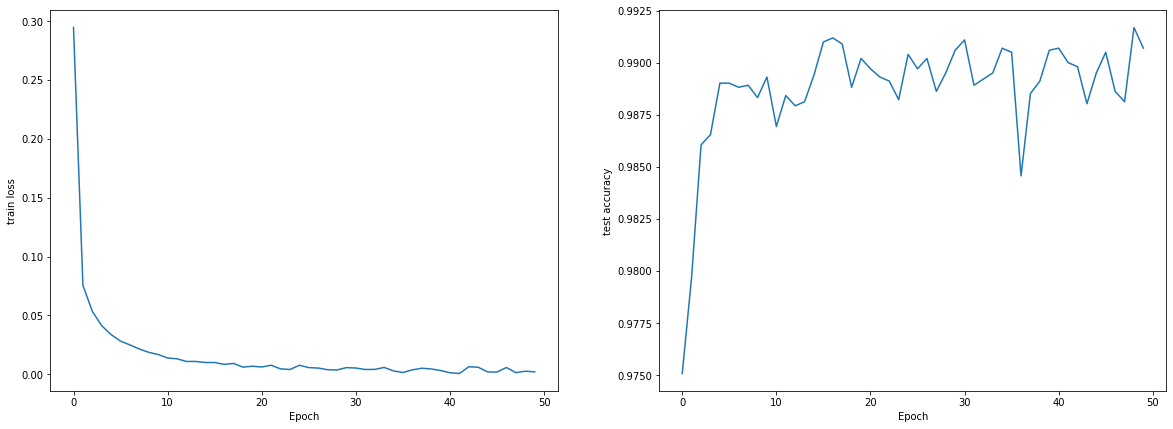

In [6]:
# 代码5-6：训练集的误差曲线和测试集的准确率曲线可视化
plt.figure(figsize=(20, 7))
plt.subplot(1, 2, 1)
plt.plot(train_losses) 
plt.xlabel("Epoch")
plt.ylabel("train loss")
plt.subplot(1, 2, 2)
plt.plot(val_accs) 
plt.xlabel("Epoch")
plt.ylabel("test accuracy")

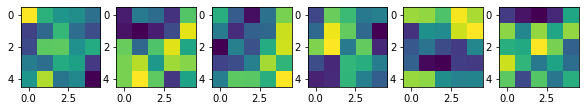

In [7]:
# 代码示例 5-7：第一层卷积核可视化
plt.figure(figsize=(10, 7))

for i in range(6):
    plt.subplot(1, 6, i + 1)
    target = model.conv[0].weight.cpu()
    plt.imshow(target.data.numpy()[i, 0, ...])

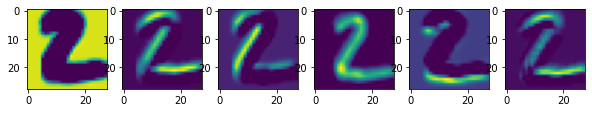

In [8]:
# 代码示例 5-8：第一层卷积输出特征图可视化
input_x_1 = testset[1][0].unsqueeze(0) # 从testset中提取第一个批次的第0个图
feature_map1 = model.conv[1](model.conv[0].cpu()(input_x_1)) # 提取完成第一层卷积的特征图
input_x_2 = model.conv[2].cpu()(feature_map1) # 完成第一层池化
feature_map2 = model.conv[4](model.conv[3].cpu()(input_x_2)) # 提取完成第二层卷积的特征图

plt.figure(figsize=(10, 7))
for i in range(6):
    plt.subplot(1, 6, i + 1)
    plt.imshow(feature_map1[0, i, ...].data.numpy())

In [9]:
input_x_1 = testset[1][0].unsqueeze(0) 
print(input_x_1.size())

torch.Size([1, 1, 32, 32])


In [10]:
feature_map1 = model.conv[1](model.conv[0].cpu()(input_x_1)) # 提取完成第一层卷积的特征图
print(feature_map1.shape)

torch.Size([1, 6, 28, 28])


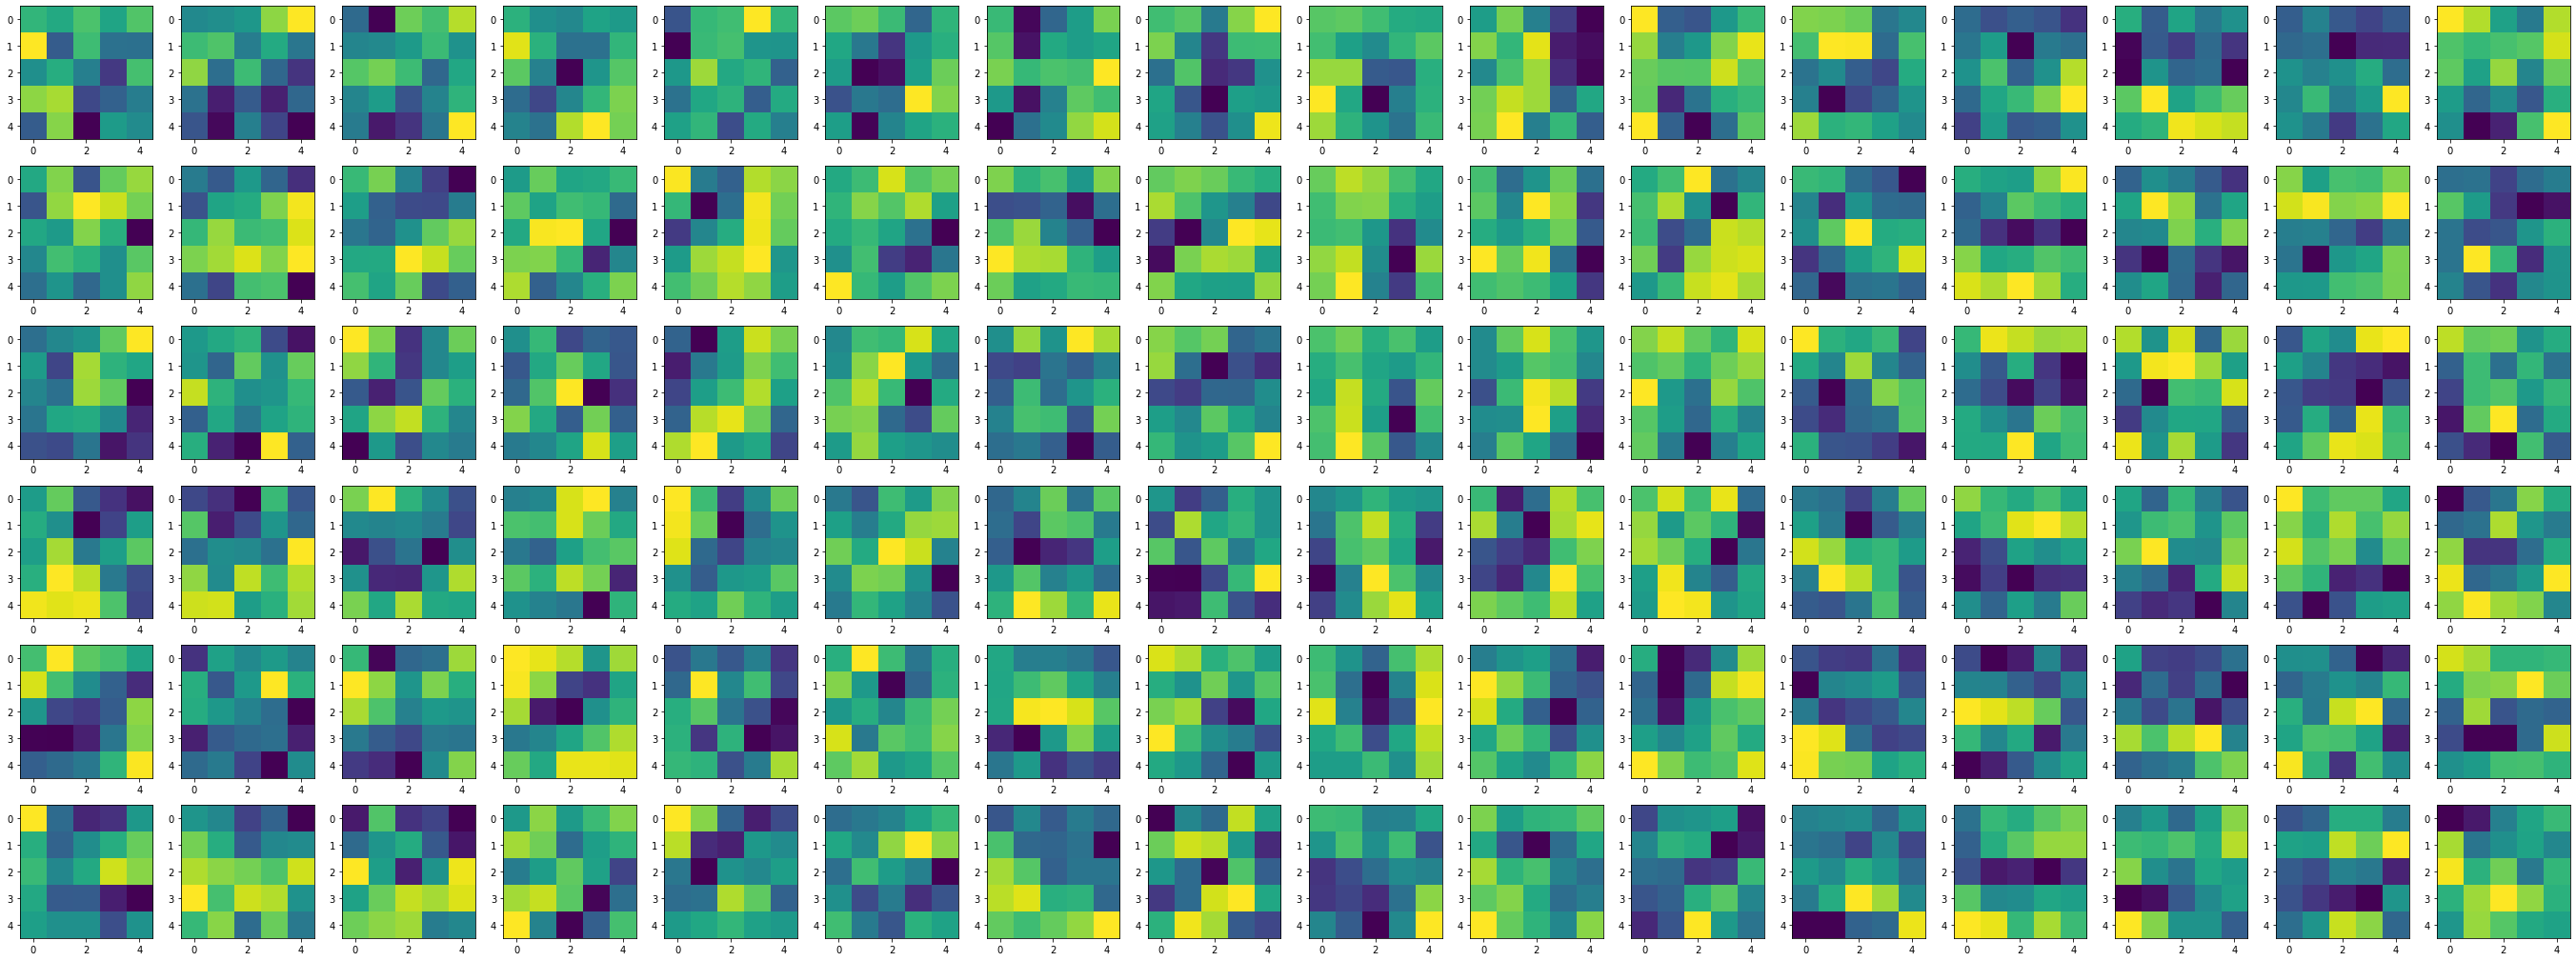

In [11]:
# 代码示例 5-9：第二层卷积核可视化
plt.figure(figsize=(48, 18))
for i in range(6):
    for j in range(16):
        plt.subplot(6, 16, i * 16 + j + 1)
        plt.imshow(model.conv[3].weight.data.numpy()[j, i, ...])    

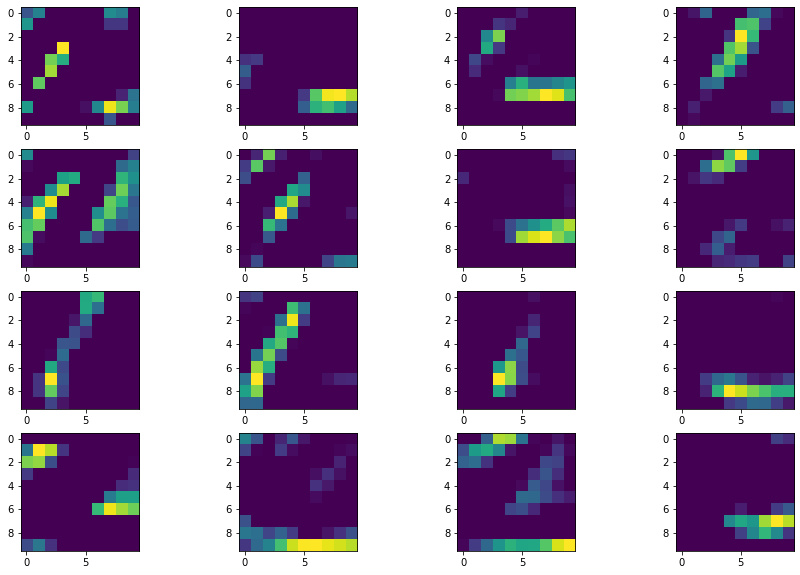

In [12]:
# 代码示例 5-10：第二层卷积输出特征图可视化
plt.figure(figsize=(15, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(feature_map2[0, i, ...].data.numpy())   